## 英法翻译系统

### 介绍

机器翻译可谓是自然语言处理的源头，在上个世纪40年代，正是人们基于机器翻译的热情，才开展了一系列语言与计算机相结合的研究工作。本实验主要基于 seq2seq+attention 框架构建英法翻译系统，主要包括以下知识点：

#### 知识点

- 英法翻译模型概述
- 英法数据处理
- seq2seq + attention 模型构建
- 模型训练及测试

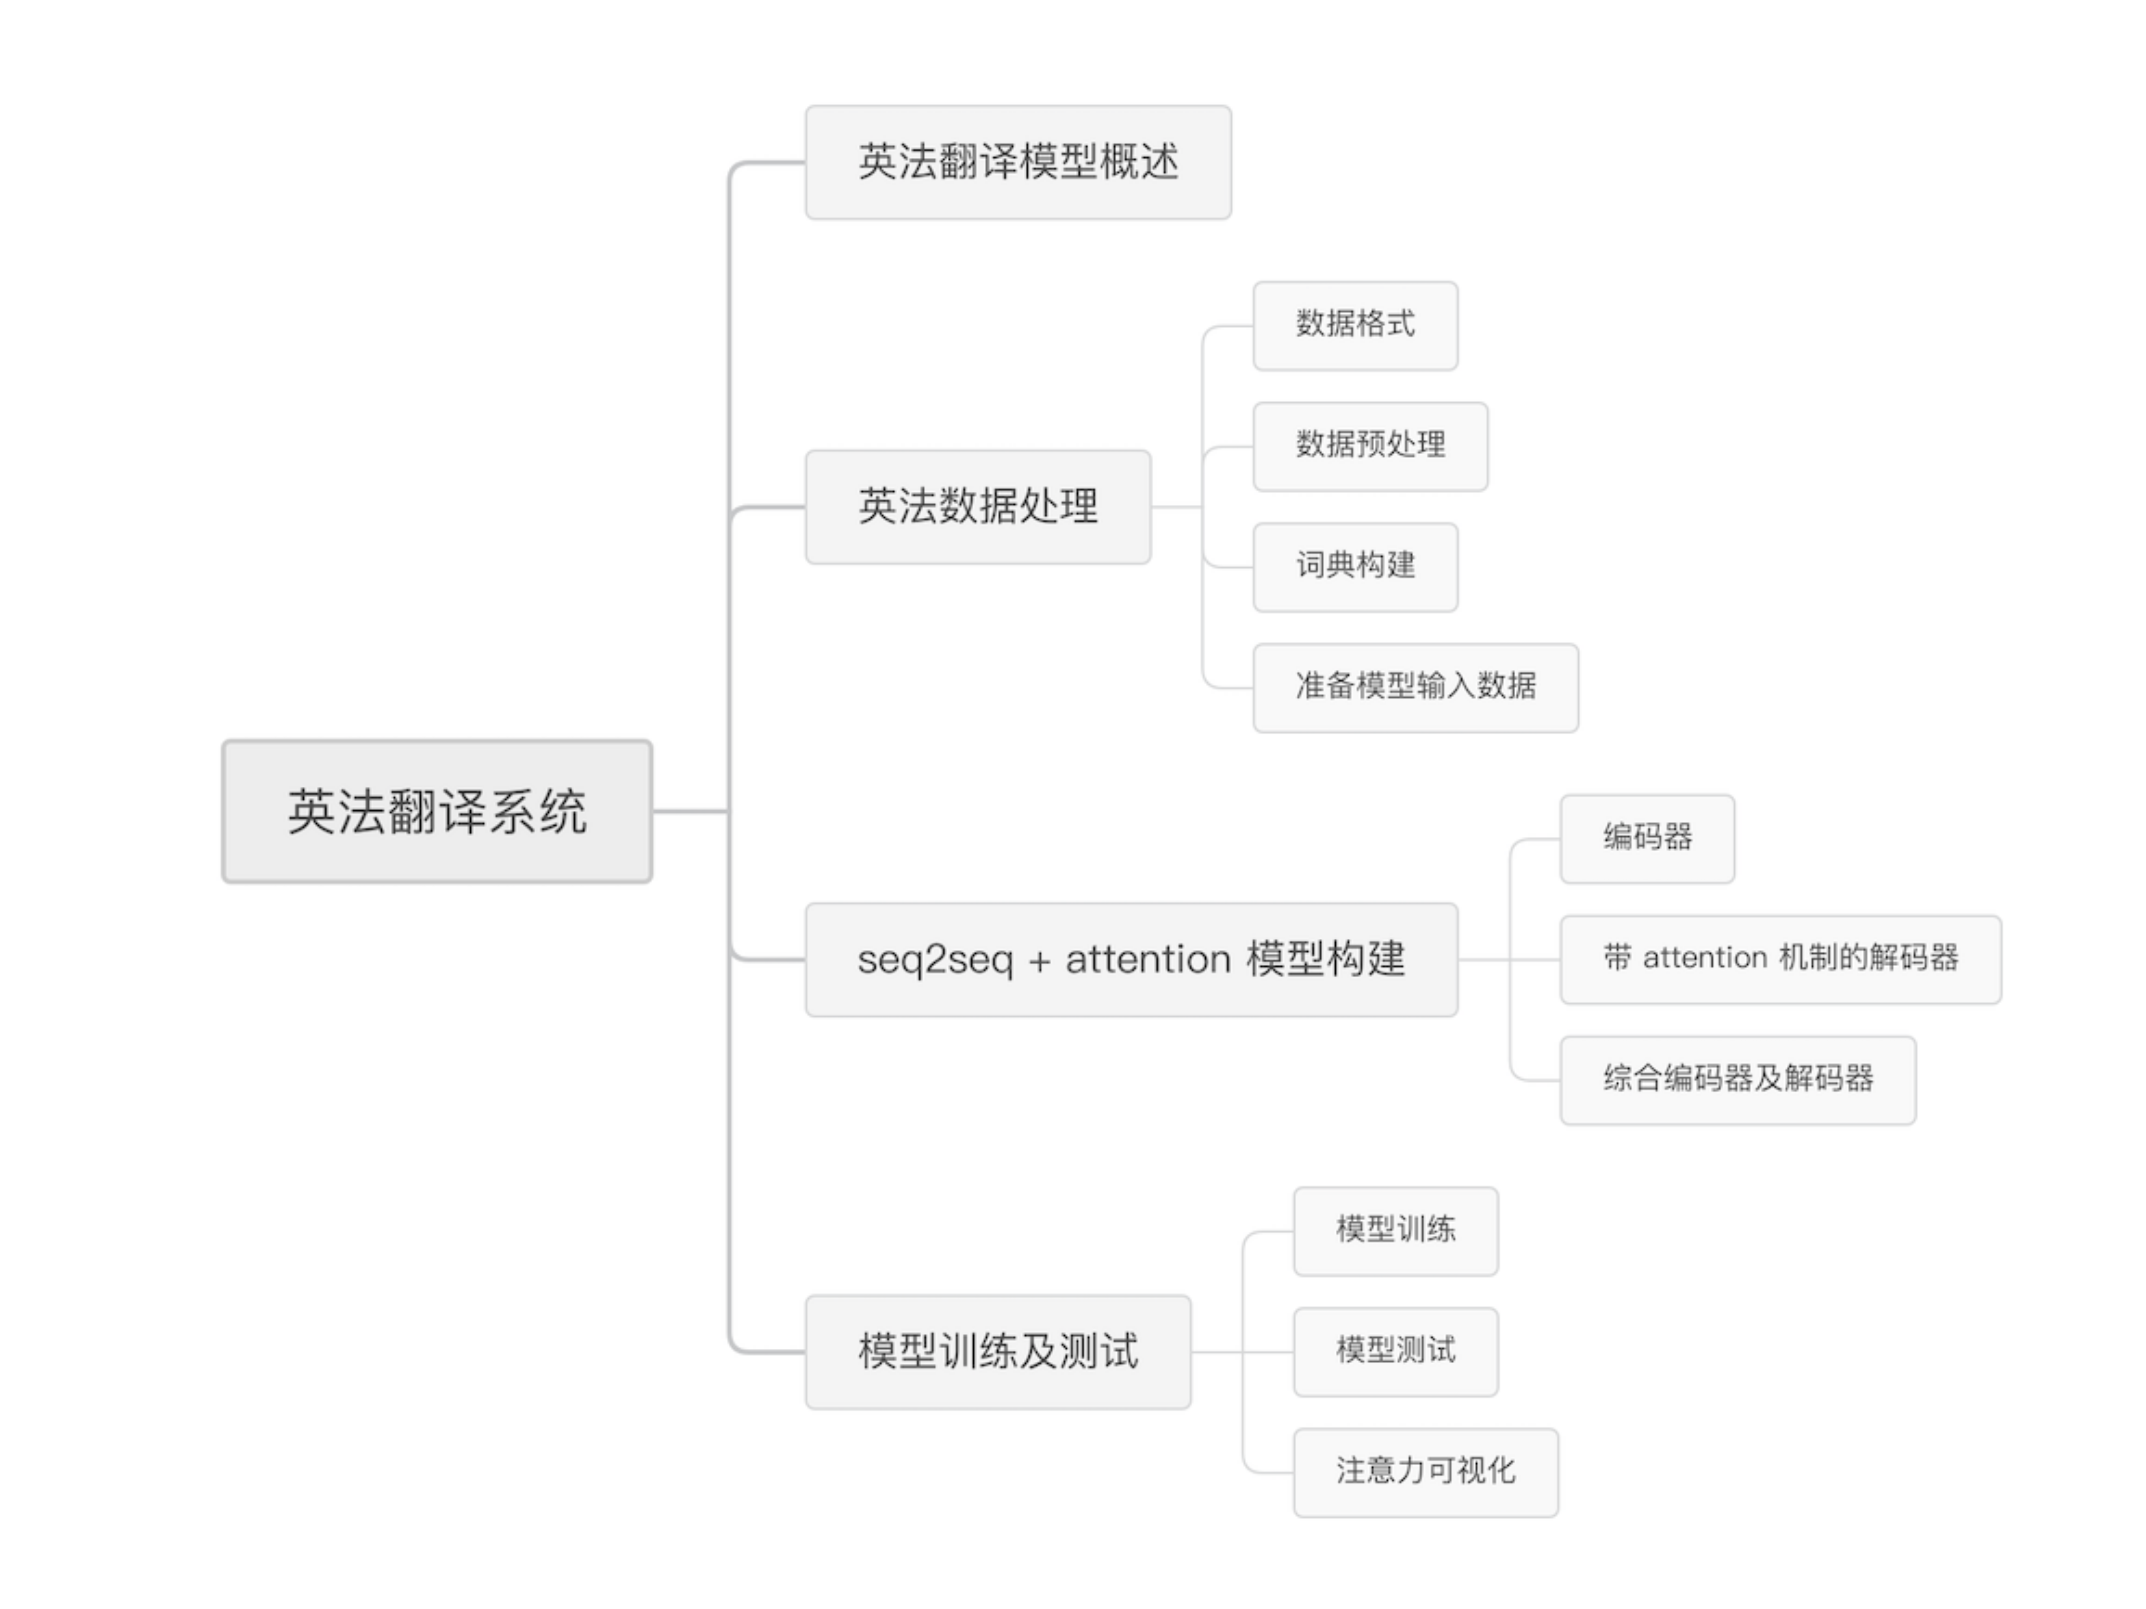

### 英法翻译模型概述

基于 seq2seq + attention 结构进行英法翻译模型的构建，整体结构如下：

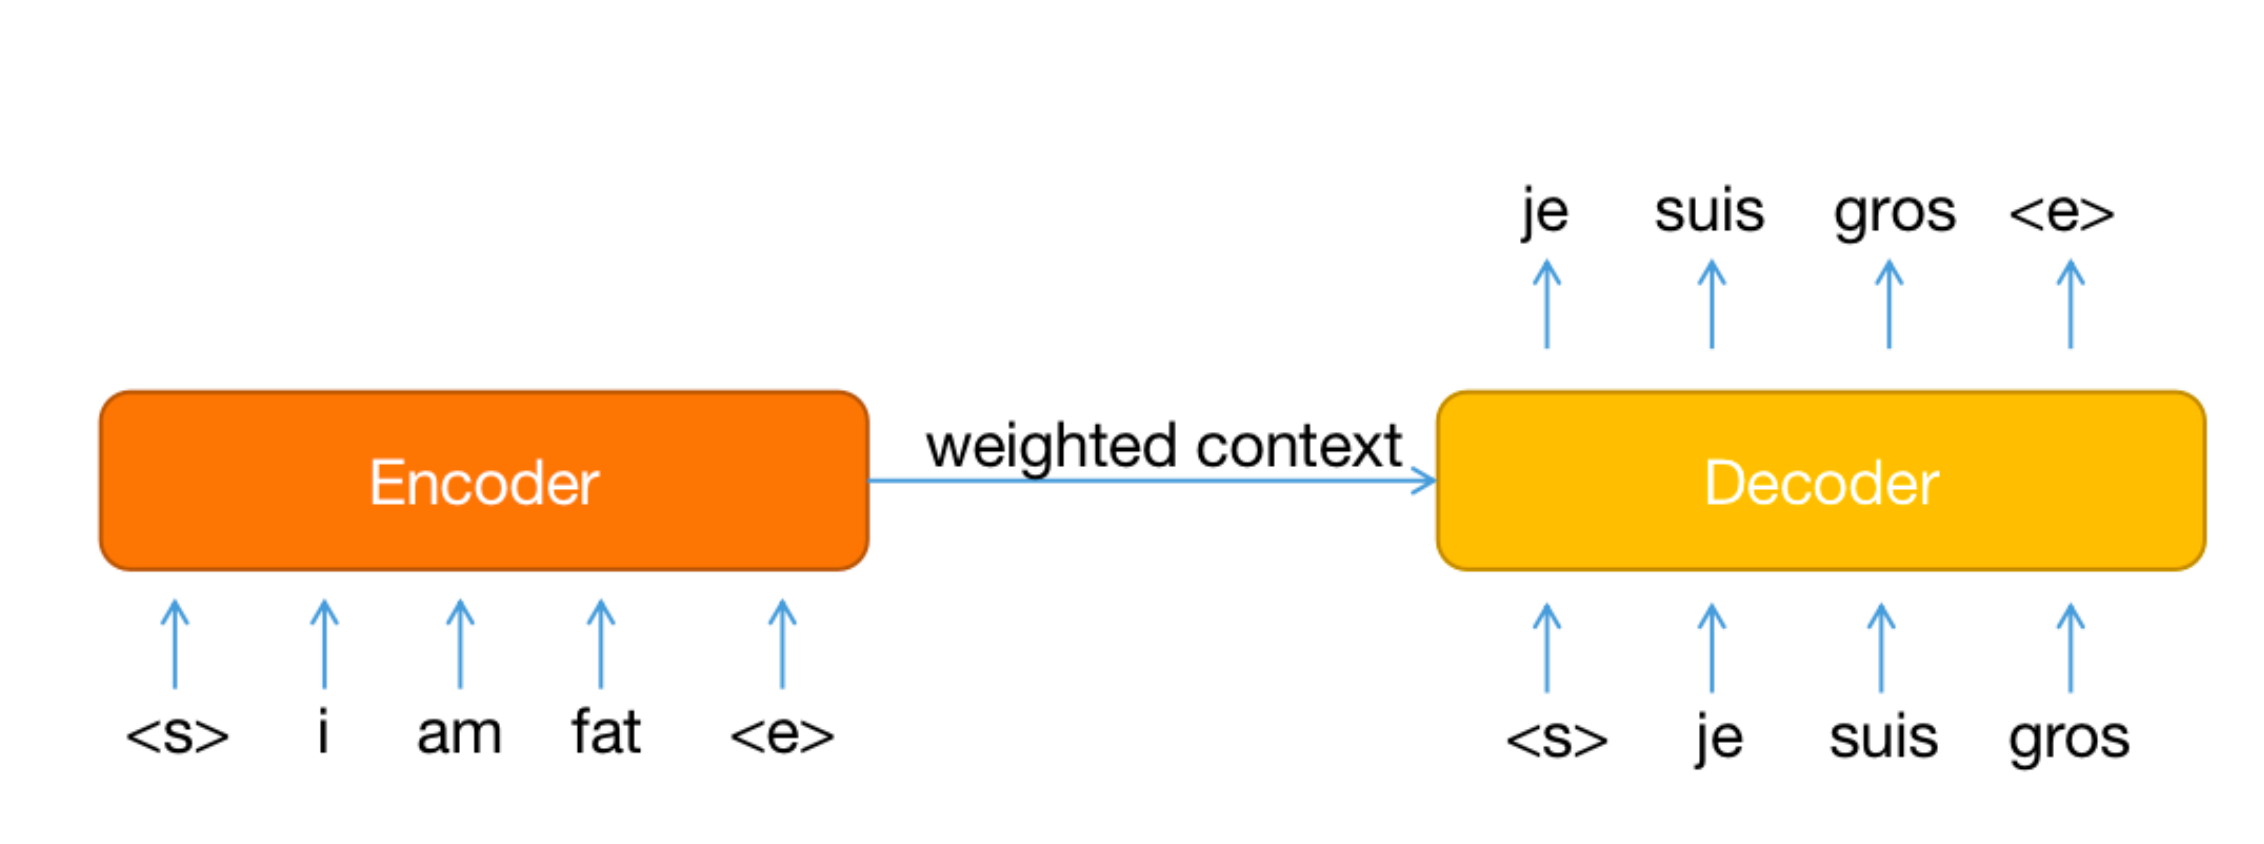

简而言之，Encoder 以及 Decoder 的结构均为循环神经网络。其中，< s >、< e > 分别表示句子的初始符以及结束符。首先，英语句子进行 Encoder 进行解码；接着在 Decoder 中输入首字符 < s >，基于结合注意力机制的解码结果进行编码（如编码输出 je），再将 je 作为 Decoder 的下一步输入，以此类推，直至解码至 < e > 或者最大长度。

### 英法数据处理

训练一个基本上“还看得过去”的翻译模型至少需要<font color=#0099ff>百万级别</font>的数据，这里为了保证测试效果，只选择长度低于 10 的英法句子对作为本项目的语料数据，以降低难度。

在原数据文件 `eng-fra.txt` 中，数据格式如下，法语与英语之间以 \t 相隔：

- Go.	Va !
- Run!	Cours !
- Run!	Courez !
- Wow!	Ça alors !
- Fire!	Au feu !
- Help!	À l'aide !

在这里首先定义函数 `clean_text`，针对每一行数据，进行如下处理操作：

- 小写化。
- 去除除了英法字符以及基本标点符号以外的特殊符号。
- 分词。
- 在操作之后，若英法中任一句子为空，输出 None。

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 教学代码：</i>

In [ ]:
import re
import nltk


def clean_text(text):
    text = text.lower()  # 小写
    text = re.sub("[^a-zàâéêëèîïôûüùç.,!?' \t]", "",
                  text)  # 去除除了英法字符以及基本标点符号以外的特殊符号
    en_fr = text.split("\t")
    if len(en_fr) == 2:  # 分词处理
        en_tokens, fr_tokens = nltk.word_tokenize(
            en_fr[0]), nltk.word_tokenize(en_fr[1])
        if en_tokens and fr_tokens:  # 确保英法的句子不为空
            return " ".join(en_tokens) + "\t" + " ".join(fr_tokens)
        else:
            return None
    else:
        return None

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 动手练习：</i>

接下来针对原始训练语料，进行统一处理，新数据存入文件 `eng_fra_cleaned.txt`：

In [ ]:
from tqdm import tqdm

def make_clean_small_file(file_path_in, file_path_out, max_len=10):
    with open(file_path_in, "r", encoding="utf-8") as fi:  # 读取原文本
        texts = fi.readlines()
    with open(file_path_out, "w", encoding="utf-8") as fo:  # 写入新文本
        for text in tqdm(texts):
            text_cleaned = clean_text(text)
            if text_cleaned:  # 确保英法的句子不为空
                if len(text_cleaned.split()) <= max_len:
                    fo.write(text_cleaned)
                    fo.write("\n")


数据处理：

In [ ]:
# 下载英法数据
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3382/eng-fra.txt"
# 下载 NLTK 所需要的数据包
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3205/nltk_data.zip"
!unzip -o "nltk_data.zip" -d /root/
# 数据预处理
make_clean_small_file(
    "eng-fra.txt", "eng_fra_cleaned.txt")

下一步，基于训练语料获取英、法词典，并且设置去除低频词的功能。

In [ ]:
from collections import Counter

# 构建英、法词典，去除低频词


def get_trimmed_vocab(file_path, min_freq=1):
    en_freq, fr_freq = Counter(), Counter()
    with open(file_path, "r", encoding="utf-8") as f:  # 读取文件
        texts = f.readlines()
    for line in tqdm(texts):  # 计算词汇频率
        en_fr = line.strip().split("\t")
        en_tokens, fr_tokens = en_fr[0].split(), en_fr[1].split()
        en_freq.update(en_tokens)
        fr_freq.update(fr_tokens)
    # 去除低频词
    en_vocab = [k for k, v in en_freq.items() if v > min_freq]
    fr_vocab = [k for k, v in fr_freq.items() if v > min_freq]
    return en_vocab, fr_vocab

查看英法词典大小：

In [ ]:
en_vocab, fr_vocab = get_trimmed_vocab("eng_fra_cleaned.txt")
print("英语词典大小:", len(en_vocab))
print("法语词典大小:", len(fr_vocab))

基于词典分别构建英语、法语单词与 id 的双向对应表，并且添加特殊字符 < s >，< e >，UNK：

构建单词与 id 的对应表：

In [ ]:
en_word2id, en_id2word = create_word_id(en_vocab)
fr_word2id, fr_id2word = create_word_id(fr_vocab)

在构建词典的时候，我们并没有添加 PAD 符号，这是因为在 seq2seq 模型中，添加 PAD 会对编码及解码产生较大影响，不利于模型收敛。因此在本项目中无截长补短操作，也就是说，在训练过程中，单句单句地进行训练。

在数据处理的最后一步，只需要添加首尾符号，把数据转化为 id 并以 tensor 形式输出即可。

In [ ]:
import torch
DEVICE = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")  # 如果有 GPU, 将数据与模型转换到 cuda
# 获取数据


def load_dataset(file_path):
    datasets = []
    with open(file_path, "r", encoding="utf-8") as f:  # 读取数据
        lines = f.readlines()
    for line in tqdm(lines):  # 遍历数据
        en_fr = line.strip().split("\t")
        # 添加首尾符号
        en_words, fr_words = (
            "<s> " + en_fr[0] + " <e>").split(), ("<s> " + en_fr[1] + " <e>").split()
        en_word_idx, fr_word_idx = [en_word2id.get(word, en_word2id.get("UNK")) for word in en_words],\
            [fr_word2id.get(word, fr_word2id.get("UNK")) for word in fr_words]
        x = torch.LongTensor(en_word_idx).view(-1, 1).to(DEVICE)
        y = torch.LongTensor(fr_word_idx).view(-1, 1).to(DEVICE)
        datasets.append((x, y))
    return datasets


traindataset = load_dataset("eng_fra_cleaned.txt")

### seq2seq + attention 模型构建

在模型搭建阶段，主要构建如下结构：

- 编码器
- 带注意力机制的解码器
- 综合编码器及解码器

首先基于 GRU 构建编码器,通过阅读输入句子的每个单词，来生成一些值。对每一个输入单词，编码器输出一个向量和一个隐藏状态，并且使用这个隐藏状态作为下一个单词的输入：

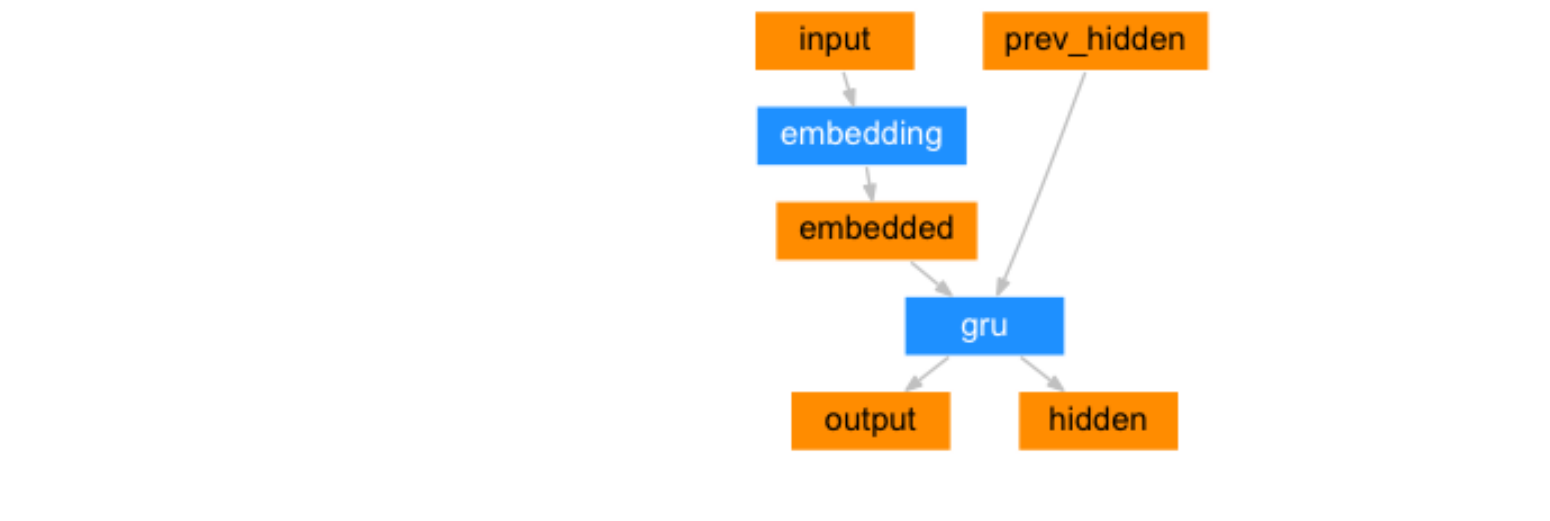

代码如下：

In [ ]:
import torch.nn as nn


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)  # 词向量层
        self.gru = nn.GRU(hidden_size, hidden_size)  # GRU 层

    def forward(self, input, hidden):
        # 输入的 batch_size 为 1
        embedded = self.embedding(input).view(1, 1, -1)  # 词向量计算，注意输出后的维度变化
        output, hidden = self.gru(embedded, hidden)  # GRU 层计算
        return output, hidden

    def initHidden(self):  # 初始化隐状态
        return torch.zeros(1, 1, self.hidden_size, device=DEVICE)

如果仅仅是在编码器和解码器之间传递上下文向量， 对单个向量来说，准确表达整个句子是很困难的。注意力机制允许解码器在解码的每一步获得一个关于原始句子的注意量，也就是说，<font color=#0099ff>这一步的翻译需要在原始句子的不同部分投入多少的注意力</font>。首先基于一个前馈层 `attn` 来计算注意力权重，使用解码器的输入和隐藏状态作为输入，得到权重 `attn_weights`,再将其和编码器的输出向量 `encoder_outputs` 相乘来获得一个权重敏感的输出`attn_applied`，再结合原始输入的 `embedded`，从而帮助解码器选择正确的输出单词。

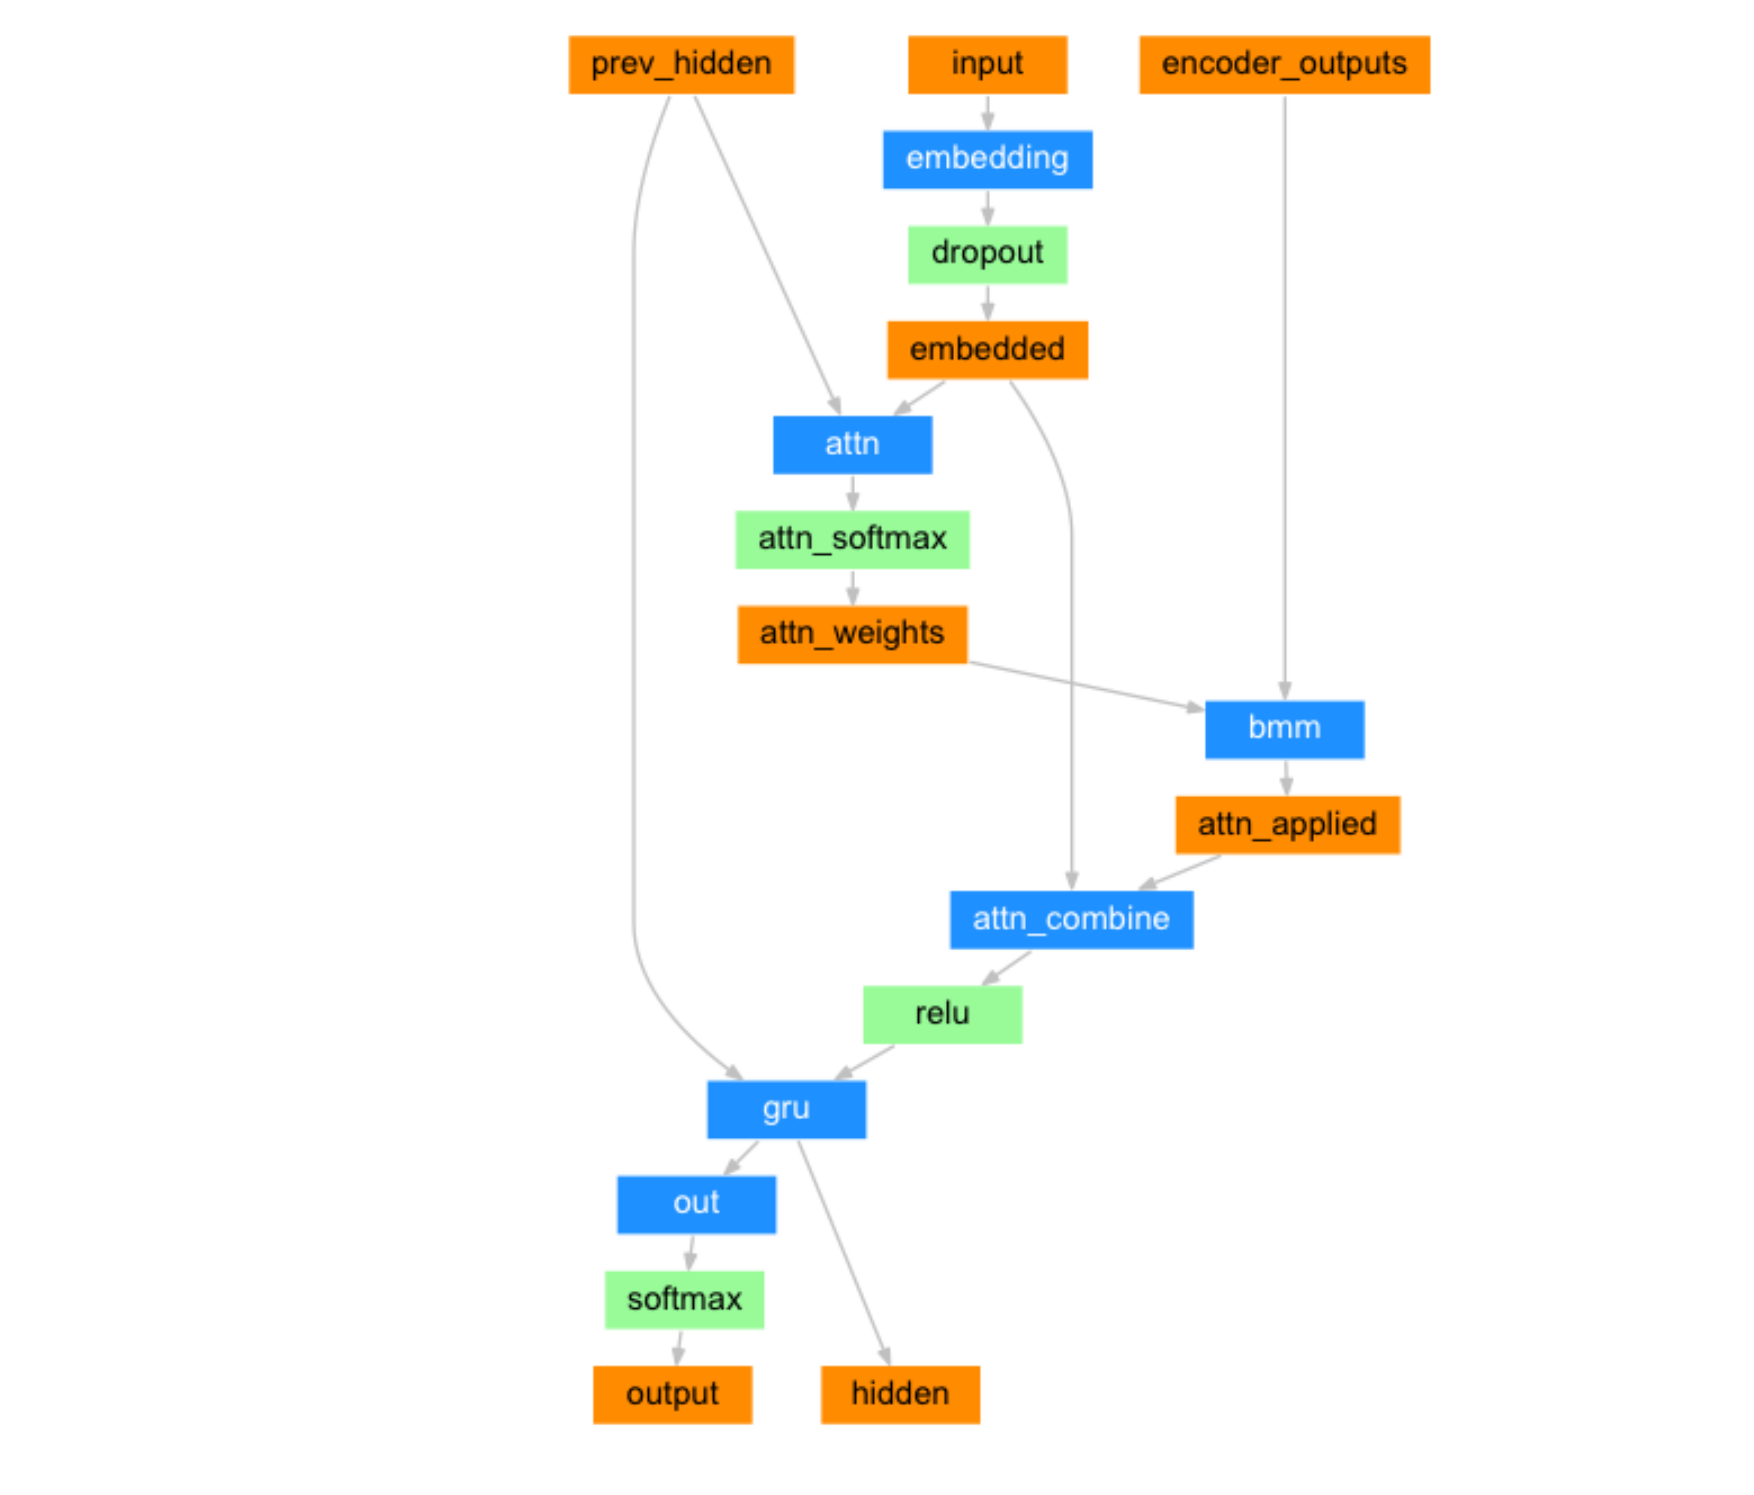

代码如下：

In [ ]:
import torch.nn.functional as F
MAX_LENGTH = 10


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(
            self.output_size, self.hidden_size)  # 词向量层
        # 与注意力机制相关的两个全连接层
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)  # GRU 层
        self.out = nn.Linear(self.hidden_size, self.output_size)  # 输出层

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)  # 输入当前单词的词向量计算
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat([embedded[0], hidden[0]], 1)), dim=1)  # 对当前信息进行全连接层的计算
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))  # 将当前信息与 encoder 的输出信息进行注意力运算

        output = torch.cat([embedded[0], attn_applied[0]], 1)  # 结合当前信息以及注意力信息
        output = self.attn_combine(output).unsqueeze(0)  # 全连接运算

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)  # GRU 运算

        # 对输出进行 log softmax 计算
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):  # 初始化隐状态
        return torch.zeros(1, 1, self.hidden_size, device=DEVICE)

定义好了编码器及解码器以后，综合两者进行翻译过程。首先将句子输入到编码器网络中，同时跟踪其每一步的输出和最后一步的隐藏状态。然后解码器网络接受一个 `<s>` 作为第一步的输入，编码器最后一步的隐藏状态作为其初始隐藏状态。

关于解码器的每一步，这里有个选择问题：<font color=#0099ff>是使用目标字母直接输入，还是使用前一步的网络预测结果作为输入</font>？

这就涉及到了 Teacher forcing （也称为<font color=#0099ff>教师模式</font>） 的概念：若使用真实目标输出作为下一个输入，而不是使用解码器的预测作为下一个输入，可以使网络更快地收敛，但是在模型应用阶段，它可能表现出不稳定性，这是因为在应用阶段是使用解码器的预测作为下一个输入的，存在训练与预测不一致的情况。

在实际训练中，兼合应用两种模式，可以基于 `teacher_forcing_ratio` 来控制教师模式的使用概率。

结合编码器与解码器：

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input, target, teacher_forcing_ratio=0.5):
        encoder_hidden = self.encoder.initHidden()  # 初始化 encoder 隐状态
        input_length = input.size(0)
        target_length = target.size(0)

        # 用于存储 encoder 的输出
        encoder_outputs = torch.zeros(
            MAX_LENGTH, self.encoder.hidden_size, device=DEVICE)
        for i in range(input_length):
            encoder_output, encoder_hidden = self.encoder(
                input[i], encoder_hidden)
            encoder_outputs[i] = encoder_output[0, 0]

        decoder_input = torch.tensor(
            [[fr_word2id["<s>"]]], device=DEVICE)  # decoder 首输入为 "<s>"
        decoder_hidden = encoder_hidden  # encoder 隐状态传给 decoder
        outputs = torch.zeros(target_length, len(
            fr_word2id)).to(DEVICE)  # 用于存储 decoder 的输出

        for i in range(target_length):
            # 进行 decoder 解码过程
            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            outputs[i] = decoder_output.squeeze(0)

            # 选择是否应用教师模式
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            if use_teacher_forcing:
                # 教师模式: 真实目标语句中的下一个单词作为下一步的输入
                decoder_input = target[i]
            # 非教师模式：当前步所预测出的最高概率单词作为下一步的输入
            else:
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()
                # 若预测到 "<e>"，停止生成
                if decoder_input.item() == fr_word2id["<e>"]:
                    break
        return outputs

初始化模型：

In [ ]:
# 相关参数
SRC_VOCAB_DIM = len(en_word2id)  # 源语言词典大小
TRG_VOCAB_DIM = len(fr_word2id)  # 目标语言词典大小
HIDDEN_DIM = 256  # 隐层大小
DEC_DROPOUT = 0.1  # 丢弃率

# 模型及损失器初始化
enc = EncoderRNN(SRC_VOCAB_DIM, HIDDEN_DIM)
dec = AttnDecoderRNN(HIDDEN_DIM, TRG_VOCAB_DIM, DEC_DROPOUT)
translate_model = Seq2Seq(enc, dec).to(DEVICE)
criterion = nn.NLLLoss()
print(translate_model)
print(criterion)

### 模型训练及测试

首先定义基本的训练函数，即对于一对数据的训练：

In [ ]:
def train(model, input, target, learning_rate=0.01):
    model.train()
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate)  # SGD 优化器
    optimizer.zero_grad()  # 清空梯度
    outputs = model(input, target)  # 模型预测
    loss = criterion(outputs, target.squeeze(1))  # 计算损失
    loss.backward()  # 损失回传
    optimizer.step()
    return loss.item()  # 返回损失

定义综合训练函数，迭代多次，并且每隔 `print_every` 次进行模型训练情况可视化，并且在此过程中保存最优模型。

In [ ]:
import time


def train_n_iters(model, n_iters, print_every=100000, learning_rate=0.01):
    start_time = time.time()
    print_loss_total = 0  # 每 print_every 次重新计算 loss
    train_pairs = [random.choice(traindataset)
                   for i in range(n_iters)]  # 随机获取数据
    best_loss = float('inf')  # 记录最好 loss 以记录最好的模型

    for iter in range(1, n_iters+1):
        train_pair = train_pairs[iter-1]  # 获取一对数据
        input, target = train_pair[0], train_pair[1]

        loss = train(model, input, target)  # 计算 loss
        print_loss_total += loss

        if iter % print_every == 0:  # 每 print_every 次计算 loss，计时，并且可视化
            print_loss_avg = print_loss_total / print_every  # 计算 loss
            print_loss_total = 0  # loss 置零

            if print_loss_avg < best_loss:  # 保存最好的模型
                best_loss = print_loss_avg
                torch.save(model.state_dict(), 'translate_model_cpu.pkl')

            # 计时
            secs = int(time.time() - start_time)
            mins = secs / 60
            secs = secs % 60

            # 训练过程可视化
            print('n_iters: %d' % (iter + 1),
                  " | %d minutes, %d seconds" % (mins, secs))
            print(f'\tTrain Loss: {print_loss_avg:.3f}')

In [ ]:
# 保证每次结果一样
import random
SEED = 123
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

模型训练：

In [ ]:
N_ITERS = 5000
train_n_iters(model=translate_model, n_iters=N_ITERS, print_every=1000)

由于在线环境运行较慢，上面只训练了 N_ITERS = 5000 作为演示。

在训练好模型后，对模型进行简单测试，查看效果。具体地，针对输入的语句，先进行编码，再逐词进行解码。与类 `Seq2Seq` 的前向过程类似,主要区别在于，<font color=#0099ff>在测试的解码过程中，无教师模式</font>。

In [ ]:
def evaluate(model, input_tensor, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_length = input_tensor.size()[0]  # 获取输入语句长度
        encoder_hidden = model.encoder.initHidden()  # 初始化 encoder 隐状态
        encoder_outputs = torch.zeros(
            max_length, model.encoder.hidden_size, device=DEVICE)  # 用于存储 encoder 输出

        # encoder 过程
        for i in range(input_length):
            encoder_output, encoder_hidden = model.encoder(
                input_tensor[i], encoder_hidden)
            encoder_outputs[i] += encoder_output[0, 0]

        # decoder 首次输入为 "<s>" 以及 encoder 最后的隐状态
        decoder_input = torch.tensor([[fr_word2id["<s>"]]], device=DEVICE)
        decoder_hidden = encoder_hidden

        # 用于存储 decoder 的单词
        decoded_words = []
        # 注意力表
        decoder_attentions = torch.zeros(max_length, max_length)

        # decoder 过程
        for j in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = model.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # 存储注意力
            decoder_attentions[j] = decoder_attention.data
            # 获取概率最高的单词
            topv, topi = decoder_output.data.topk(1)
            # 若预测为 "<e>"，结束解码
            if topi.item() == fr_word2id["<e>"]:
                decoded_words.append("<e>")
                break
            # 否则继续将当前预测值作为下一步输入
            else:
                decoded_words.append(fr_id2word[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:j + 1]

除了了基本的翻译效果测试，还可以对注意力机制进行可视化，构建词汇间的注意力显示函数：

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.switch_backend('Agg')

# 显示词汇间的注意力


def show_attention(input_sentence, output_words, attentions):
    # 设置整体显示图
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 设置横纵坐标
    ax.set_xticklabels(['']+input_sentence.split(' '), rotation=90)
    ax.set_yticklabels(['']+output_words.split(' '))

    # 显示横纵坐标的标签值
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

从数据中随机抽取数据进行测试：

In [ ]:
def evaluate_randomly(model, n=10):
    # 随机测试
    for i in range(n):
        # 获取句子对
        pair = random.choice(traindataset)
        en_sen = " ".join([en_id2word[i[0].item()] for i in pair[0]])
        fr_sen = " ".join([fr_id2word[i[0].item()] for i in pair[1]])
        print('源句子：', en_sen)
        print('标准翻译：', fr_sen)
        # 应用模型进行预测
        output_words, attentions = evaluate(model, pair[0])
        output_sentence = ' '.join(output_words)
        print('预测翻译：', output_sentence)
        show_attention(en_sen, output_sentence, attentions)
        print('')

载入模型：

In [ ]:
translate_model = Seq2Seq(enc, dec).to(DEVICE)
translate_model.load_state_dict(torch.load("translate_model_cpu.pkl"))

由于在线环境运行较慢，上面只训练了 N_ITERS = 5000 作为演示。接下来，你可以下载我在本地训练了 N_ITERS = 75000 的模型用于推理：

```python
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3382/translate_model.pkl"
translate_model.load_state_dict(torch.load("translate_model.pkl",map_location=torch.device('cpu')))
```

随机测试：

In [ ]:
%matplotlib inline
evaluate_randomly(translate_model, n=2)

对于训练数据，模型的翻译结果还不错，主要原因在于语料偏简单，另外，也可以试试未训练过的语句进行测试，查看效果如何？

严格而言，判断一个翻译系统表现如何，除了主观评估，还要基于测试集以指标 <font color=#0099ff>BLEU、ROUGE </font>等为准，进行综合评判。简单地说，两者均在于评判模型的翻译文本与真实翻译文本间的契合度，而 BLEU 根据精确率 Precision 衡量翻译的质量，而 ROUGE 根据召回率 Recall 衡量翻译的质量。

BLEU、ROUGE 详细定义可参考 [<i class="fa fa-external-link-square" aria-hidden="true"> 机器翻译与自动文摘评价指标 BLEU 和 ROUGE</i>](https://baijiahao.baidu.com/s?id=1655137746278637231&wfr=spider&for=pc)。

### 实验总结

为了更进一步，以上项目流程可在以下方面作一些优化：

- 增强数据；
- 改变注意力机制的计算方式；
- 应用批数据进行训练，应用 PyTorch 中相关工具实现批数据可变长输入，既能实现多个数据同时训练，又能忽略 PAD 带来的影响。主要是用函数 `torch.nn.utils.rnn.PackedSequence()`、`torch.nn.utils.rnn.pack_padded_sequence()` 以及 `torch.nn.utils.rnn.pad_packed_sequence()` 来完成;
- 尝试使用不同的编码器，比如 CNN；
- 当然，还可以尝试 Transformer 构架。

本实验的主要知识点如下：

- 英法翻译模型概述
- 英法数据处理
- seq2seq + attention 模型构建
- 模型训练及测试

正是因为有了注意力机制，机器翻译的效果在简单的 seq2seq 基础上有了较大提升。而尔后提出的自注意力机制，其风头又盖过了注意力机制，成为众多预训练前沿模型的核心构成。在下一实验中，我们将学习 NLP 的一大利器：自注意力机制。